In [1]:
import os
import time
from tempfile import TemporaryDirectory

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.backends.mps as mps
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

In [2]:
def get_default_device():
    cuda = torch.cuda.is_available()
    mps = torch.backends.mps.is_available()
    print(cuda, mps)

    if cuda:
        return torch.device("cuda")
    if mps:
        return torch.device("mps")
    else:
        return torch.device("cpu")

In [3]:
device = get_default_device()
device

False True


device(type='mps')

In [4]:
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

In [5]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            #             transforms.Normalize(mean, std),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.ToTensor(),
            #         transforms.Normalize(mean, std)
        ]
    ),
}

In [6]:
data_dir = "/Users/mks/Documents/GitHub/AI/archive"
os.listdir(data_dir)

['fer20131.csv', '.DS_Store', 'train', 'ferSubmission.csv', 'val']

In [7]:
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x),
                            transform=data_transforms[x])
    for x in ["train", "val"]
}

image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 1790
     Root location: /Users/mks/Documents/GitHub/AI/archive/train
     StandardTransform
 Transform: Compose(
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 727
     Root location: /Users/mks/Documents/GitHub/AI/archive/val
     StandardTransform
 Transform: Compose(
                ToTensor()
            )}

In [8]:
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=64, shuffle=True, num_workers=8
    )
    for x in ["train", "val"]
}

dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x16e593110>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x16d966610>}

In [9]:
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
dataset_sizes

{'train': 1790, 'val': 727}

In [10]:
class_names = image_datasets["train"].classes
class_names

['NEGATIVE', 'NEUTRAL', 'POSITIVE']

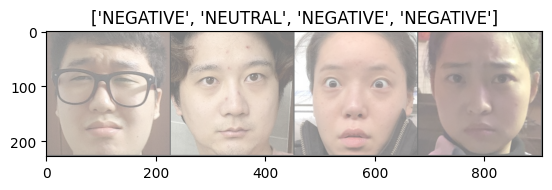

In [11]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

## Training

In [12]:
train_acc_history = []
train_loss_history = []
val_acc_history = []
val_loss_history = []


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_params_path = "/Users/mks/Documents/GitHub/AI/model/ResNet9_epoch-50_score-0.8001.pth"

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]
            if phase == "train":
                train_loss_history.append(float(epoch_loss))
                train_acc_history.append(float(epoch_acc))
            else:
                val_loss_history.append(float(epoch_loss))
                val_acc_history.append(float(epoch_acc))
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:4f}")

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path))

    return model


## Visualization

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig, axes = plt.subplots(
        2, 3, figsize=(5, 3), dpi=200, sharex=True, sharey=True, constrained_layout=True
    )

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                q, r = divmod(images_so_far, 3)
                images_so_far += 1

                axes[q][r].set_title(
                    f"label: {class_names[labels.data[j]]}\npredicted: {class_names[preds[j]]}"
                )
                axes[q][r].imshow(inputs.cpu().data[j].permute(1, 2, 0).numpy())

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Fine tuning

In [14]:
model_ft = models.resnet18(weights="IMAGENET1K_V1")
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, weight_decay=0.0001)
# optimizer_ft = optim.RMSProp(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [15]:
model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50
)

Epoch 1/50
----------
train Loss: 0.3257 Acc: 0.8749
val Loss: 0.4887 Acc: 0.8776

Epoch 2/50
----------
train Loss: 0.0761 Acc: 0.9682
val Loss: 0.5878 Acc: 0.8336

Epoch 3/50
----------
train Loss: 0.0577 Acc: 0.9799
val Loss: 0.8582 Acc: 0.7840

Epoch 4/50
----------
train Loss: 0.0412 Acc: 0.9832
val Loss: 1.0636 Acc: 0.7276

Epoch 5/50
----------
train Loss: 0.0503 Acc: 0.9844
val Loss: 0.3052 Acc: 0.9257

Epoch 6/50
----------
train Loss: 0.0465 Acc: 0.9855
val Loss: 0.6703 Acc: 0.8377

Epoch 7/50
----------
train Loss: 0.0327 Acc: 0.9844
val Loss: 0.2670 Acc: 0.9175

Epoch 8/50
----------
train Loss: 0.0109 Acc: 0.9966
val Loss: 0.1796 Acc: 0.9450

Epoch 9/50
----------
train Loss: 0.0065 Acc: 0.9989
val Loss: 0.1769 Acc: 0.9505

Epoch 10/50
----------
train Loss: 0.0024 Acc: 1.0000
val Loss: 0.1902 Acc: 0.9464

Epoch 11/50
----------
train Loss: 0.0028 Acc: 1.0000
val Loss: 0.1878 Acc: 0.9450

Epoch 12/50
----------
train Loss: 0.0014 Acc: 1.0000
val Loss: 0.1831 Acc: 0.9505

E

/var/folders/_w/6twp845j1tsgpylfv57d8d2r0000gn/T/ipykernel_27116/873607933.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_p

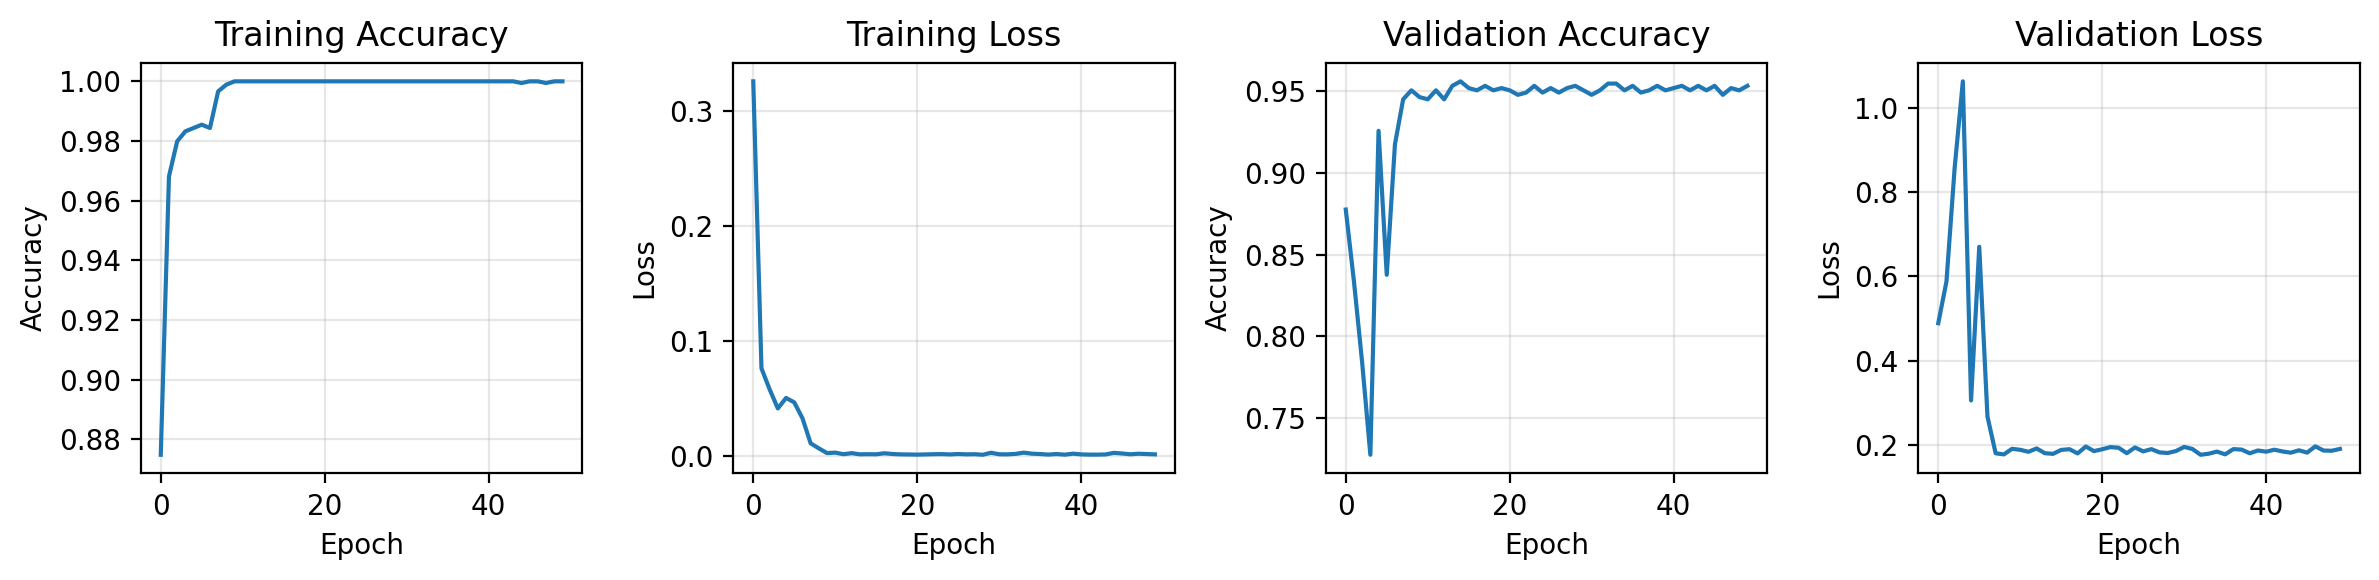

In [16]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3), dpi=200)

axes[0].set_title("Training Accuracy")
axes[0].plot(range(len(train_acc_history)), train_acc_history, label="Train Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True, alpha=0.3)

axes[1].set_title("Training Loss")
axes[1].plot(range(len(train_loss_history)), train_loss_history, label="Train Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True, alpha=0.3)

axes[2].set_title("Validation Accuracy")
axes[2].plot(range(len(val_acc_history)), val_acc_history, label="Validation Accuracy")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Accuracy")
axes[2].grid(True, alpha=0.3)

axes[3].set_title("Validation Loss")
axes[3].plot(range(len(val_loss_history)), val_loss_history, label="Validation Loss")
axes[3].set_xlabel("Epoch")
axes[3].set_ylabel("Loss")
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close(fig)

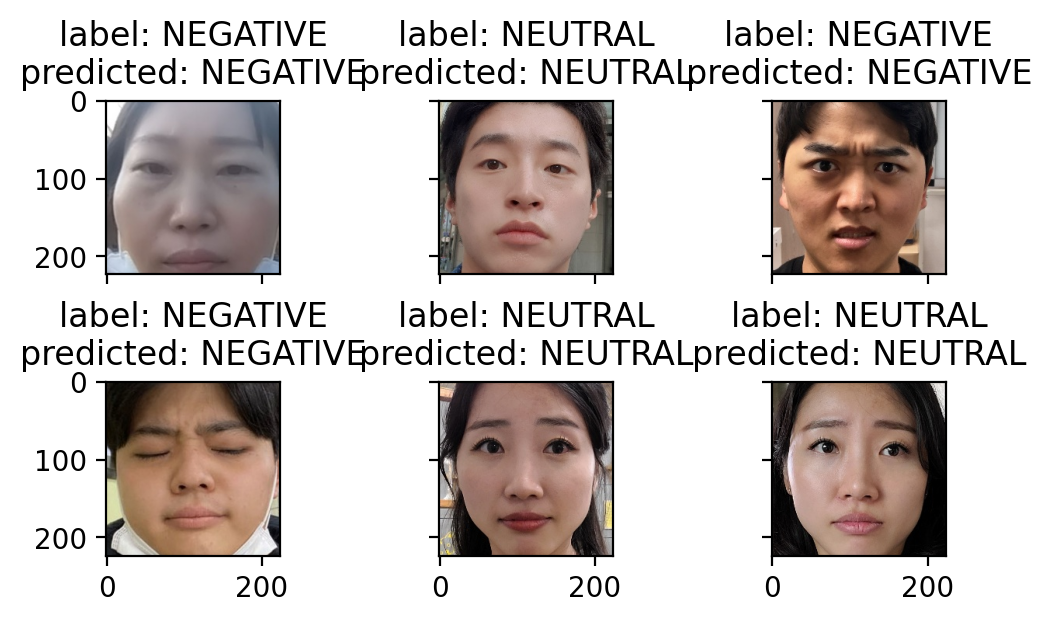

In [17]:
visualize_model(model_ft)

In [19]:
torch.save(model_ft.state_dict(), "/Users/mks/Documents/GitHub/AI/model/ResNet9_final.pth")